In [1]:
# #!apt -q install libomp-dev
# !pip -q install faiss-gpu 
# !pip -q install annoy_gpu

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import random


pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score

from sklearn.metrics import mean_squared_error,mean_absolute_error, accuracy_score

# для создания двойного пути к базе данных
import os

# Математика
import numpy as np

# Графики
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option('display.max_columns', 100)
# оставим всего три знака после запятой у чисел с плавающей точкой
pd.set_option('display.float_format', '{:.3f}'.format)
import warnings; warnings.filterwarnings(action='once')
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 16),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
sns.set_style('darkgrid')
sns.set_palette('Accent') 
sns.set_context('notebook', rc={'legend.fontsize': 10.0})
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Библиотека sklearn

import sklearn 
from sklearn.cluster import KMeans


from sklearn.metrics import (
    # r2_score,
    f1_score,
    accuracy_score
)

from sklearn.tree import plot_tree

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix


/home/popf/soft/miniconda3/envs/practicum/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/popf/soft/miniconda3/envs/practicum/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/popf/soft/miniconda3/envs/practicum/lib/python3.12/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [3]:

#print('faiss', faiss.__version__)  #> 0.9.0

In [4]:
pth1 = 'base.csv'
pth1_1 = './data/base.csv'
pth2 = 'train.csv'
pth2_1 = './data/train.csv'
pth3 = 'validation_answer.csv'
pth3_1 = './data/validation_answer.csv'
pth4 = 'validation.csv'
pth4_1 = './data/validation.csv'

def loadFile(path1, path2):
    if os.path.exists(path1):
        return pd.read_csv(path1, index_col=0)
    elif os.path.exists(path2):
        return pd.read_csv(path2, index_col=0)
    else:
        print("No file exists:" ,path1, path2)

X_base = loadFile(pth1, pth1_1)
X_train = loadFile(pth2, pth2_1)
answers = loadFile(pth3, pth3_1)
X_test = loadFile(pth4, pth4_1)

In [5]:
# Изучение датафрейма 
def inspectDataframe(df):
    df.info()
    return df.head()
inspectDataframe(X_base)

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


0      1       2        3       4        5        6       7  \
Id                                                                          
0-base -115.084 11.153 -64.427 -118.881 216.482 -104.698 -469.071  44.348   
1-base  -34.562 13.333 -69.788 -166.533  57.681  -86.098  -85.077 -35.637   
2-base  -54.234  6.379 -29.210 -133.414 150.896  -99.435   52.555  62.382   
3-base  -87.520  4.038 -87.803 -185.068  76.370  -58.985 -383.183 -33.611   
4-base  -72.744  6.522  43.671 -140.608   5.820 -112.074 -397.711  45.182   

             8       9       10       11      12      13      14      15  \
Id                                                                         
0-base 120.915 181.450 -124.062  -32.458 -57.421  36.207 182.717 -28.072   
1-base 119.719 195.234 -141.304 -126.769 -68.854   8.315 143.082   8.778   
2-base 128.951 164.381 -140.822  -22.487 -51.667   2.522 140.585 -22.039   
3-base 122.032 136.234 -108.470 -104.538 -82.388 -79.987 113.596 -38.996   
4-base 122.167 112.119 -110.342  -38.982 -50.229 -26.691 135.273  -7.510   

           16      17       18      19       20       21       22     23  \
Id                                                                         
0-base -5.209  -1.732  -91.092 -79.467 -103.939 1507.231  -32.592 51.414   
1-base 15.157  48.246 -244.955 -80.279  -81.788  429.880   -5.938 70.143   
2-base -7.129  -5.185 -111.712 -79.029  -82.453 1507.231   -0.421 84.108   
3-base -4.787   8.328 -124.856 -79.109 -107.943 1479.171 -125.272 24.656   
4-base  8.924 111.577 -130.833 -79.316  -57.844 1262.920   19.226 59.812   

            24      25       26     27       28      29      30       31  \
Id                                                                         
0-base -51.905 813.770  -41.557  8.420 -129.977 148.765 -10.069 -143.005   
1-base  66.577 813.770    3.214 17.164  -39.418 148.156  -7.580 -174.370   
2-base  63.345 813.770 -105.211 18.845  -94.789 151.388 -21.483 -144.845   
3-base -16.921 813.770 -182.680 14.716  -62.933 151.202  10.613 -134.934   
4-base  76.160 312.699  -76.727 21.300  -24.069 167.386 -44.059 -148.132   

            32       33     34      35      36       37       38      39  \
Id                                                                         
0-base  79.849 -537.184  2.773 111.519   4.258 -153.341 -123.626 -39.708   
1-base 101.225 -303.939 16.915  53.395  33.452 -148.553 -110.340 -33.277   
2-base  48.503 -780.449 64.767  79.782 -13.390 -150.062 -118.759 -40.896   
3-base  58.778 -529.295 43.666  92.806 -38.937 -145.045 -124.296 -36.877   
4-base  98.043 -657.524 96.363  71.062 -36.564 -135.372 -123.709 -44.739   

            40     41       42      43      44      45       46       47  \
Id                                                                         
0-base -12.769 -4.170 -152.967  75.912 -57.470  17.266  -98.871 -138.068   
1-base  -8.689 13.650  -91.229  38.445 -31.948  62.485 -166.473 -189.010   
2-base -15.223 -1.860  -93.821  98.749 -46.746  65.927  -10.286 -125.321   
3-base -17.743 10.536 -124.584 121.914 -17.321 105.217  -94.380  -63.769   
4-base -10.855  8.355 -168.329 215.928 -32.976  66.865   30.839 -211.540   

            48       49      50      51     52       53     54     55  \
Id                                                                      
0-base  91.000 -170.702 -50.020  59.794 78.106  -89.376 89.412 79.812   
1-base -56.732  -30.027  59.171 -56.712 63.543 -121.319 97.426 74.833   
2-base  21.049  -22.638  68.916 -54.902 66.335 -142.928 83.031 69.980   
3-base  29.217  -26.424   5.870  64.062 63.513 -112.258 80.927 72.636   
4-base  57.695  -67.823 -29.389 -34.124 54.711  -26.032 90.674 58.087   

             56      57       58       59       60       61       62     63  \
Id                                                                            
0-base -129.514 -44.659  -80.442    5.150  -64.519 -138.778  -42.809 38.801   
1-base -138.777  58.888  -71.595 -251.952   11.393 -148.572 

In [6]:
inspectDataframe(X_train)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

0      1        2        3       4        5        6       7  \
Id                                                                           
0-query -53.883 17.971  -42.117 -183.937 187.517  -87.145 -347.361  38.308   
1-query -87.776  6.806  -32.055 -177.260 120.803  -83.811  -94.573 -78.433   
2-query -49.980  3.841 -116.119 -180.402 190.128  -50.838   26.944 -30.447   
3-query -47.811  9.087 -115.402 -121.011  94.653 -109.255 -775.150  79.187   
4-query -79.632 14.443  -58.903 -147.053  57.127  -16.240 -321.318  45.985   

              8       9       10       11      12      13      14      15  \
Id                                                                          
0-query 109.086  30.414  -88.083  -52.696 -27.692   4.873 198.348 -30.075   
1-query 124.916 140.331 -177.606  -84.996  42.811 -57.256  96.793 -19.261   
2-query 125.771 211.608  -86.347  -35.667  16.395 -80.803 137.909 -23.533   
3-query 124.003 242.651 -146.517 -159.470 -13.845  -6.114 118.939 -44.586   
4-query 125.941 103.393 -107.153   -8.800 -50.978  29.457 143.389   5.615   

             16       17       18      19      20       21      22      23  \
Id                                                                           
0-query  -3.804 -135.811 -161.841 -78.512 -94.429  898.437 -70.141  78.420   
1-query   0.740   50.619 -155.267 -78.659 -92.761  353.158 -34.745  82.487   
2-query -47.257  -16.650 -194.506 -78.373 -69.324 1507.231 -52.501 -34.166   
3-query   9.559   14.436 -156.907 -78.789 -78.737 1507.231  19.957  34.834   
4-query -45.275    9.644  -77.555 -79.067 -77.926 1507.231  16.612 116.284   

             24      25       26     27       28      29      30       31  \
Id                                                                          
0-query 108.033 813.770  -74.791 12.610 -183.822 149.716 -27.042 -133.212   
1-query -28.451 813.770 -137.530 26.596 -136.783 153.358  48.810 -115.922   
2-query  52.959 813.770  -18.022 20.951  -50.322 158.761   0.178 -183.070   
3-query  -8.821 813.770 -125.607 17.584  -58.453 141.282 -54.959 -136.989   
4-query  33.755 813.770 -105.765  6.523  -19.813 157.694 -20.604 -146.591   

             32        33      34     35      36       37       38      39  \
Id                                                                           
0-query 106.421  -303.939  48.731 58.186  24.251 -151.224 -104.282 -34.493   
1-query  87.464  -222.286  25.124 91.887 -30.637 -136.593 -140.500 -43.450   
2-query  99.054 -1018.470 -51.801 97.767 -10.866 -144.423 -133.819 -78.902   
3-query  63.880 -1018.470  89.229 65.920 -24.079 -152.334  -91.199 -28.225   
4-query  78.850  -780.449  87.561 73.037  16.891 -144.658 -116.122 -19.353   

             40     41       42      43      44      45       46       47  \
Id                                                                          
0-query -12.587  2.623 -120.970 149.992 -31.948  82.314 -115.830 -243.309   
1-query  -7.227  8.266 -117.915 149.151 -18.751  95.315  -60.093  -83.821   
2-query -17.200  4.467  -63.971 154.640 -30.212  48.527 -122.407 -112.714   
3-query  -4.767  0.158 -129.129 122.958 -30.801 123.623  -37.541  -72.140   
4-query  -7.709 -5.395 -140.252 193.185 -53.147  79.869 -151.131  -45.056   

            48       49      50      51     52       53     54     55  \
Id                                                                      
0-query  6.622 -132.198  68.713 -38.807 62.937 -132.654 89.189 87.040   
1-query 37.450  -23.299  74.061  -7.140 75.862 -112.045 82.858 54.067   
2-query 53.462  -31.117 107.842  16.483 77.934  -95.619 91.460 63.120   
3-query 71.241 -168.116 118.236 -18.065 37.256 -137.691 87.501 62.437   
4-query 79.796   46.763  47.682 -24.104 75.143 -207.345 93.437 51.505   

              56      57       58       59       60       61       62     63  \
Id                                                                             
0-query -121.280  -6.987 -206.514   29.486  -77.030 -132.386 -105.428 70.107   
1

In [7]:
inspectDataframe(answers)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base

In [8]:
inspectDataframe(X_test)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

0      1       2        3       4        5        6  \
Id                                                                       
100000-query -57.373  3.598 -13.214 -125.927 110.746  -81.280 -461.003   
100001-query -53.759 12.790 -43.269 -134.418 114.450  -90.520 -759.626   
100002-query -64.175 -3.981  -7.679 -170.161  96.446  -62.378 -759.626   
100003-query -99.287 16.124   9.837 -148.060  83.697 -133.730   58.576   
100004-query -79.533 -0.364 -16.027 -170.885 165.454  -28.292   33.932   

                   7       8       9       10       11      12      13  \
Id                                                                       
100000-query 139.816 112.881  75.216 -131.893 -140.969 -57.987 -22.869   
100001-query  63.995 127.118  53.129 -153.717  -63.951 -52.369 -33.391   
100002-query  87.478 131.270 168.920 -220.310  -31.378  -8.789   2.285   
100003-query -19.047 115.042  75.207 -114.272  -71.406 -65.349  24.377   
100004-query  34.411 128.904 102.087  -76.214  -26.394  34.424  50.939   

                  14      15      16      17       18      19       20  \
Id                                                                       
100000-query 150.896   7.966  17.622 -34.868 -216.139 -80.909  -52.580   
100001-query 148.619 -22.484  15.164 -56.202 -153.614 -79.832 -101.055   
100002-query 133.266 -41.309  14.306 -18.232 -205.534 -78.160  -96.608   
100003-query  50.467 -14.721  15.069 -46.683 -176.604 -78.691 -139.227   
100004-query 157.683 -23.786 -33.175  -0.593 -193.319 -79.651  -91.890   

                   21     22      23      24      25       26     27      28  \
Id                                                                             
100000-query  263.363 56.267  66.925  21.610 813.770  -32.783 20.794 -79.779   
100001-query 1203.537 81.597 101.019  56.783  92.210 -126.860 10.383 -38.523   
100002-query 1507.231 -5.964  34.937 -56.087 813.770  -13.200 18.967 -35.110   
100003-query  325.547  3.632  74.930  -4.802 813.770  -52.983 15.644 -54.087   
100004-query 1358.481 44.028 121.527  46.183 433.623  -82.233 21.069 -32.940   

                  29      30       31      32       33      34     35      36  \
Id                                                                              
100000-query 156.307 -42.831  -71.723  83.284 -304.174   1.609 55.835 -29.474   
100001-query 165.384 -77.840 -169.539 103.483 -915.736  16.110 14.670 -38.707   
100002-query 151.369 -17.490 -145.884  15.533 -655.396  39.413 62.555   9.925   
100003-query 151.309  21.089 -134.508  65.119 -529.295 131.566 67.643 -22.884   
100004-query 149.269   0.405  -97.675  81.720 -825.645   9.397 49.359  17.725   

                   37       38      39      40     41       42      43  \
Id                                                                       
100000-query -139.163 -126.038 -62.644  -5.012 11.985  -43.085 190.124   
100001-query -149.538 -138.793 -36.076  -2.781  2.283 -142.478 189.954   
100002-query -143.935 -123.108 -37.032 -13.501 12.913 -116.038 176.276   
100003-query -145.907  -86.917 -11.864 -22.189  0.464 -212.534 170.523   
100004-query -160.168 -129.368 -55.533  -2.598 -0.226  -41.369  92.090   

                  44      45       46       47      48      49      50  \
Id                                                                       
100000-query -24.997  76.154 -245.262 -143.656  -4.260 -46.664 -27.085   
100001-query -18.408  90.517  -95.531 -259.636  52.438 -30.005  14.502   
100002-query -45.910 103.491  -90.657 -162.616 117.128  13.079  69.827   
100003-query -48.093  99.713 -194.692 -141.523  60.217  73.386 118.568   
100004-query -58.627  73.655  -10.257 -175.657  25.395  47.875  51.465   

                  51     52       53     54     55       56      57       58  \
Id                                                                             
100000-query -34.347 75.530  -47.172 92.697 60.476 -127.487 -39.485 -124.385   
100001-query  -1.071 66.843 -161.280 94.794 50.420 -125

**Вывод по загрузке данных**

Данные состоят из трех датасетов с характеристиками месторорждений из 3-ех регионов: содержат 100000 записей с 5 столбцами. Данные успешно загружены. Все данные в таблицах соответствуют описанию и готовы к дальнейшему анализу.


## Шаг 2. Предобработка данных: <a id='#2_1-bullet'></a>

In [9]:
def df_review(df):
   display(df.head())
   print('---------------------------------------------------------------------------------------------------------')
   print('Информация общая: ')
   df.info()
   print('---------------------------------------------------------------------------------------------------------')
   print('Статистики: ')
   display(df.describe())
   print('---------------------------------------------------------------------------------------------------------')
   print('Пропущенные значения: ')
   print(df.isna().sum())
   print('---------------------------------------------------------------------------------------------------------')
   print('Дублированные данные: ')
   print(df.duplicated().sum())

In [10]:
df_review(X_base)

0      1       2        3       4        5        6       7  \
Id                                                                          
0-base -115.084 11.153 -64.427 -118.881 216.482 -104.698 -469.071  44.348   
1-base  -34.562 13.333 -69.788 -166.533  57.681  -86.098  -85.077 -35.637   
2-base  -54.234  6.379 -29.210 -133.414 150.896  -99.435   52.555  62.382   
3-base  -87.520  4.038 -87.803 -185.068  76.370  -58.985 -383.183 -33.611   
4-base  -72.744  6.522  43.671 -140.608   5.820 -112.074 -397.711  45.182   

             8       9       10       11      12      13      14      15  \
Id                                                                         
0-base 120.915 181.450 -124.062  -32.458 -57.421  36.207 182.717 -28.072   
1-base 119.719 195.234 -141.304 -126.769 -68.854   8.315 143.082   8.778   
2-base 128.951 164.381 -140.822  -22.487 -51.667   2.522 140.585 -22.039   
3-base 122.032 136.234 -108.470 -104.538 -82.388 -79.987 113.596 -38.996   
4-base 122.167 112.119 -110.342  -38.982 -50.229 -26.691 135.273  -7.510   

           16      17       18      19       20       21       22     23  \
Id                                                                         
0-base -5.209  -1.732  -91.092 -79.467 -103.939 1507.231  -32.592 51.414   
1-base 15.157  48.246 -244.955 -80.279  -81.788  429.880   -5.938 70.143   
2-base -7.129  -5.185 -111.712 -79.029  -82.453 1507.231   -0.421 84.108   
3-base -4.787   8.328 -124.856 -79.109 -107.943 1479.171 -125.272 24.656   
4-base  8.924 111.577 -130.833 -79.316  -57.844 1262.920   19.226 59.812   

            24      25       26     27       28      29      30       31  \
Id                                                                         
0-base -51.905 813.770  -41.557  8.420 -129.977 148.765 -10.069 -143.005   
1-base  66.577 813.770    3.214 17.164  -39.418 148.156  -7.580 -174.370   
2-base  63.345 813.770 -105.211 18.845  -94.789 151.388 -21.483 -144.845   
3-base -16.921 813.770 -182.680 14.716  -62.933 151.202  10.613 -134.934   
4-base  76.160 312.699  -76.727 21.300  -24.069 167.386 -44.059 -148.132   

            32       33     34      35      36       37       38      39  \
Id                                                                         
0-base  79.849 -537.184  2.773 111.519   4.258 -153.341 -123.626 -39.708   
1-base 101.225 -303.939 16.915  53.395  33.452 -148.553 -110.340 -33.277   
2-base  48.503 -780.449 64.767  79.782 -13.390 -150.062 -118.759 -40.896   
3-base  58.778 -529.295 43.666  92.806 -38.937 -145.045 -124.296 -36.877   
4-base  98.043 -657.524 96.363  71.062 -36.564 -135.372 -123.709 -44.739   

            40     41       42      43      44      45       46       47  \
Id                                                                         
0-base -12.769 -4.170 -152.967  75.912 -57.470  17.266  -98.871 -138.068   
1-base  -8.689 13.650  -91.229  38.445 -31.948  62.485 -166.473 -189.010   
2-base -15.223 -1.860  -93.821  98.749 -46.746  65.927  -10.286 -125.321   
3-base -17.743 10.536 -124.584 121.914 -17.321 105.217  -94.380  -63.769   
4-base -10.855  8.355 -168.329 215.928 -32.976  66.865   30.839 -211.540   

            48       49      50      51     52       53     54     55  \
Id                                                                      
0-base  91.000 -170.702 -50.020  59.794 78.106  -89.376 89.412 79.812   
1-base -56.732  -30.027  59.171 -56.712 63.543 -121.319 97.426 74.833   
2-base  21.049  -22.638  68.916 -54.902 66.335 -142.928 83.031 69.980   
3-base  29.217  -26.424   5.870  64.062 63.513 -112.258 80.927 72.636   
4-base  57.695  -67.823 -29.389 -34.124 54.711  -26.032 90.674 58.087   

             56      57       58       59       60       61       62     63  \
Id                                                                            
0-base -129.514 -44.659  -80.442    5.150  -64.519 -138.778  -42.809 38.801   
1-base -138.777  58.888  -71.595 -251.952   11.393 -148.572 

---------------------------------------------------------------------------------------------------------
Информация общая: 
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 

0           1           2           3           4           5  \
count 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000   
mean      -86.229       8.080     -44.581    -146.635     111.317     -71.991   
std        24.891       4.953      38.632      19.845      46.348      28.186   
min      -199.469     -13.915    -240.073    -232.667    -105.583    -211.009   
25%      -103.065       4.708     -69.559    -159.905      80.508     -91.380   
50%       -86.231       8.039     -43.817    -146.777     111.873     -71.922   
75%       -69.257      11.470     -19.625    -133.328     142.374     -52.441   
max        21.516      29.937     160.937     -51.375     319.664      58.806   

                6           7           8           9          10          11  \
count 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000   
mean     -392.224      20.353     123.684     124.458    -143.140     -69.887   
std       271.655      64.216       6.356      64.431      41.687      51.220   
min      -791.470    -301.860      93.153    -173.872    -343.844    -368.453   
25%      -629.332     -22.221     119.484      81.768    -170.318    -104.033   
50%      -422.202      20.805     123.892     123.498    -141.716     -70.227   
75%      -156.669      63.918     127.970     167.221    -114.986     -35.695   
max       109.633     341.228     152.261     427.542      41.408     182.439   

               12          13          14          15          16          17  \
count 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000   
mean      -41.265       7.588     148.985     -23.167      -0.937     -19.313   
std        38.964      36.597      33.636      13.076      20.832      52.972   
min      -226.091    -175.624     -15.267     -85.917     -96.368    -272.566   
25%       -66.626     -16.944     125.966     -31.768     -15.155     -55.465   
50%       -40.397       8.128     149.315     -22.910      -1.033     -19.805   
75%       -14.836      32.671     172.162     -14.343      13.374      16.590   
max       120.767     177.527     291.748      45.073     105.391     220.799   

               18          19          20          21          22          23  \
count 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000   
mean     -137.271     -79.189     -98.254    1257.528      -6.825      56.674   
std        46.626       0.757      28.159     399.961      51.973      34.361   
min      -351.748     -83.152    -243.728     136.818    -238.287     -88.183   
25%      -167.585     -79.678    -116.843    1088.597     -42.244      33.295   
50%      -136.804     -79.178     -97.528    1507.231      -6.418      56.999   
75%      -107.537     -78.679     -79.243    1507.231      28.231      79.663   
max        97.684     -75.796      32.124    1557.433     228.803     214.311   

               24          25          26          27          28          29  \
count 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000   
mean       26.696     727.103     -66.253      16.315     -86.375     151.735   
std        38.942     205.572      61.533       4.657      48.513      10.090   
min      -143.183     -61.980    -358.552      -8.365    -314.008     107.443   
25%         0.556     813.770    -107.852      13.261    -118.660     144.887   
50%        27.131     813.770     -66.197      16.395     -85.535     151.644   
75%        53.090     813.770     -25.576      19.437     -53.878     158.276   
max       213.521     845.850     227.801      38.266     154.816     200.811   

               30          31          32          33          34          35  \
count 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000 2918139.000   
mean      -11.608    -144.233      87.220    -554.161      36.239      75.199   
std        28.951      34.757      27.856     260.649      39.895      21.447   
min      -156.730    -298.679     -34.655 

---------------------------------------------------------------------------------------------------------
Пропущенные значения: 
0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64
---------------------------------------------------------------------------------------------------------
Дублированные данные: 
0


In [11]:
df_review(X_train)

0      1        2        3       4        5        6       7  \
Id                                                                           
0-query -53.883 17.971  -42.117 -183.937 187.517  -87.145 -347.361  38.308   
1-query -87.776  6.806  -32.055 -177.260 120.803  -83.811  -94.573 -78.433   
2-query -49.980  3.841 -116.119 -180.402 190.128  -50.838   26.944 -30.447   
3-query -47.811  9.087 -115.402 -121.011  94.653 -109.255 -775.150  79.187   
4-query -79.632 14.443  -58.903 -147.053  57.127  -16.240 -321.318  45.985   

              8       9       10       11      12      13      14      15  \
Id                                                                          
0-query 109.086  30.414  -88.083  -52.696 -27.692   4.873 198.348 -30.075   
1-query 124.916 140.331 -177.606  -84.996  42.811 -57.256  96.793 -19.261   
2-query 125.771 211.608  -86.347  -35.667  16.395 -80.803 137.909 -23.533   
3-query 124.003 242.651 -146.517 -159.470 -13.845  -6.114 118.939 -44.586   
4-query 125.941 103.393 -107.153   -8.800 -50.978  29.457 143.389   5.615   

             16       17       18      19      20       21      22      23  \
Id                                                                           
0-query  -3.804 -135.811 -161.841 -78.512 -94.429  898.437 -70.141  78.420   
1-query   0.740   50.619 -155.267 -78.659 -92.761  353.158 -34.745  82.487   
2-query -47.257  -16.650 -194.506 -78.373 -69.324 1507.231 -52.501 -34.166   
3-query   9.559   14.436 -156.907 -78.789 -78.737 1507.231  19.957  34.834   
4-query -45.275    9.644  -77.555 -79.067 -77.926 1507.231  16.612 116.284   

             24      25       26     27       28      29      30       31  \
Id                                                                          
0-query 108.033 813.770  -74.791 12.610 -183.822 149.716 -27.042 -133.212   
1-query -28.451 813.770 -137.530 26.596 -136.783 153.358  48.810 -115.922   
2-query  52.959 813.770  -18.022 20.951  -50.322 158.761   0.178 -183.070   
3-query  -8.821 813.770 -125.607 17.584  -58.453 141.282 -54.959 -136.989   
4-query  33.755 813.770 -105.765  6.523  -19.813 157.694 -20.604 -146.591   

             32        33      34     35      36       37       38      39  \
Id                                                                           
0-query 106.421  -303.939  48.731 58.186  24.251 -151.224 -104.282 -34.493   
1-query  87.464  -222.286  25.124 91.887 -30.637 -136.593 -140.500 -43.450   
2-query  99.054 -1018.470 -51.801 97.767 -10.866 -144.423 -133.819 -78.902   
3-query  63.880 -1018.470  89.229 65.920 -24.079 -152.334  -91.199 -28.225   
4-query  78.850  -780.449  87.561 73.037  16.891 -144.658 -116.122 -19.353   

             40     41       42      43      44      45       46       47  \
Id                                                                          
0-query -12.587  2.623 -120.970 149.992 -31.948  82.314 -115.830 -243.309   
1-query  -7.227  8.266 -117.915 149.151 -18.751  95.315  -60.093  -83.821   
2-query -17.200  4.467  -63.971 154.640 -30.212  48.527 -122.407 -112.714   
3-query  -4.767  0.158 -129.129 122.958 -30.801 123.623  -37.541  -72.140   
4-query  -7.709 -5.395 -140.252 193.185 -53.147  79.869 -151.131  -45.056   

            48       49      50      51     52       53     54     55  \
Id                                                                      
0-query  6.622 -132.198  68.713 -38.807 62.937 -132.654 89.189 87.040   
1-query 37.450  -23.299  74.061  -7.140 75.862 -112.045 82.858 54.067   
2-query 53.462  -31.117 107.842  16.483 77.934  -95.619 91.460 63.120   
3-query 71.241 -168.116 118.236 -18.065 37.256 -137.691 87.501 62.437   
4-query 79.796   46.763  47.682 -24.104 75.143 -207.345 93.437 51.505   

              56      57       58       59       60       61       62     63  \
Id                                                                             
0-query -121.280  -6.987 -206.514   29.486  -77.030 -132.386 -105.428 70.107   
1

---------------------------------------------------------------------------------------------------------
Информация общая: 
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float6

0          1          2          3          4          5  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean     -85.329      7.664    -43.667   -146.119    111.771    -73.179   
std       25.804      4.956     39.111     20.435     47.701     28.719   
min     -186.280    -11.561   -224.896   -223.307    -93.272   -184.962   
25%     -103.309      4.314    -69.494   -160.029     79.474    -92.834   
50%      -85.274      7.653    -42.830   -146.067    112.260    -73.364   
75%      -67.331     10.981    -17.714   -132.278    143.761    -53.700   
max       14.585     28.918    128.108    -60.752    301.364     51.850   

               6          7          8          9         10         11  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean    -440.615     21.232    123.068    126.120   -141.169    -69.228   
std      279.018     65.985      6.492     64.913     41.608     51.259   
min     -791.469   -278.583     94.831   -142.157   -330.571   -352.405   
25%     -738.537    -22.132    118.675     82.545   -168.599   -103.049   
50%     -511.838     22.279    123.088    125.963   -140.461    -68.753   
75%     -201.117     65.900    127.542    169.701   -113.137    -34.669   
max      109.625    288.172    149.356    392.827     37.017    152.500   

              12         13         14         15         16         17  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean     -42.560      6.507    149.078    -23.942     -2.219    -12.964   
std       40.820     37.594     34.168     13.024     20.979     55.211   
min     -214.742   -145.860      8.818    -82.645    -91.657   -247.589   
25%      -69.802    -18.815    126.369    -32.380    -16.456    -49.612   
50%      -41.920      6.739    149.706    -23.707     -2.339    -12.190   
75%      -14.631     32.075    172.627    -15.438     11.703     24.465   
max      116.210    171.127    279.153     35.553     94.325    215.488   

              18         19         20         21         22         23  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean    -138.715    -79.160    -97.475   1297.270     -3.601     55.908   
std       48.737      0.776     28.382    375.124     50.064     35.618   
min     -326.649    -82.637   -228.808    136.873   -211.972    -87.324   
25%     -171.661    -79.657   -115.408   1248.126    -37.048     31.437   
50%     -139.009    -79.137    -96.863   1507.231     -3.609     55.274   
75%     -106.747    -78.639    -78.584   1507.231     29.473     79.558   
max       79.245    -75.836     26.484   1557.383    193.884    207.021   

              24         25         26         27         28         29  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean      23.470    742.789    -64.971     16.368    -86.201    152.098   
std       40.803    191.052     63.161      4.829     49.512     10.393   
min     -122.584    -61.803   -338.562     -6.629   -285.669    111.387   
25%       -5.051    813.770   -106.861     13.188   -119.614    145.143   
50%       23.307    813.770    -65.226     16.474    -86.514    151.992   
75%       51.787    813.770    -22.893     19.662    -53.064    158.894   
max      199.462    845.709    192.108     35.112    101.514    195.699   

              30         31         32         33         34         35  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean     -13.659   -144.506     89.748   -587.552     36.468     73.110   
std       29.192     35.816     28.312    273.294     39.756     20.008   
min     -130.445   -290.124    -25.551  -1044.136   -119.904    -11.927   
25%      -32.813   -168.535     70.432   -803.391      9.506     59.978   
50%      -13.219   -144.584     89.967   -579.590     36.399     73.121   
75%        5.975   -120.439    109.220   -349.545     63.628     86.277   
max      102.204     10.104    198.

---------------------------------------------------------------------------------------------------------
Пропущенные значения: 
0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64
---------------------------------------------------------------------------------------------------------
Дублированные данные: 
0


In [12]:
df_review(answers)

Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base

---------------------------------------------------------------------------------------------------------
Информация общая: 
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
---------------------------------------------------------------------------------------------------------
Статистики: 


Expected
count        100000
unique        91502
top     210304-base
freq              7

---------------------------------------------------------------------------------------------------------
Пропущенные значения: 
Expected    0
dtype: int64
---------------------------------------------------------------------------------------------------------
Дублированные данные: 
8498


In [13]:
df_review(X_test)

0      1       2        3       4        5        6  \
Id                                                                       
100000-query -57.373  3.598 -13.214 -125.927 110.746  -81.280 -461.003   
100001-query -53.759 12.790 -43.269 -134.418 114.450  -90.520 -759.626   
100002-query -64.175 -3.981  -7.679 -170.161  96.446  -62.378 -759.626   
100003-query -99.287 16.124   9.837 -148.060  83.697 -133.730   58.576   
100004-query -79.533 -0.364 -16.027 -170.885 165.454  -28.292   33.932   

                   7       8       9       10       11      12      13  \
Id                                                                       
100000-query 139.816 112.881  75.216 -131.893 -140.969 -57.987 -22.869   
100001-query  63.995 127.118  53.129 -153.717  -63.951 -52.369 -33.391   
100002-query  87.478 131.270 168.920 -220.310  -31.378  -8.789   2.285   
100003-query -19.047 115.042  75.207 -114.272  -71.406 -65.349  24.377   
100004-query  34.411 128.904 102.087  -76.214  -26.394  34.424  50.939   

                  14      15      16      17       18      19       20  \
Id                                                                       
100000-query 150.896   7.966  17.622 -34.868 -216.139 -80.909  -52.580   
100001-query 148.619 -22.484  15.164 -56.202 -153.614 -79.832 -101.055   
100002-query 133.266 -41.309  14.306 -18.232 -205.534 -78.160  -96.608   
100003-query  50.467 -14.721  15.069 -46.683 -176.604 -78.691 -139.227   
100004-query 157.683 -23.786 -33.175  -0.593 -193.319 -79.651  -91.890   

                   21     22      23      24      25       26     27      28  \
Id                                                                             
100000-query  263.363 56.267  66.925  21.610 813.770  -32.783 20.794 -79.779   
100001-query 1203.537 81.597 101.019  56.783  92.210 -126.860 10.383 -38.523   
100002-query 1507.231 -5.964  34.937 -56.087 813.770  -13.200 18.967 -35.110   
100003-query  325.547  3.632  74.930  -4.802 813.770  -52.983 15.644 -54.087   
100004-query 1358.481 44.028 121.527  46.183 433.623  -82.233 21.069 -32.940   

                  29      30       31      32       33      34     35      36  \
Id                                                                              
100000-query 156.307 -42.831  -71.723  83.284 -304.174   1.609 55.835 -29.474   
100001-query 165.384 -77.840 -169.539 103.483 -915.736  16.110 14.670 -38.707   
100002-query 151.369 -17.490 -145.884  15.533 -655.396  39.413 62.555   9.925   
100003-query 151.309  21.089 -134.508  65.119 -529.295 131.566 67.643 -22.884   
100004-query 149.269   0.405  -97.675  81.720 -825.645   9.397 49.359  17.725   

                   37       38      39      40     41       42      43  \
Id                                                                       
100000-query -139.163 -126.038 -62.644  -5.012 11.985  -43.085 190.124   
100001-query -149.538 -138.793 -36.076  -2.781  2.283 -142.478 189.954   
100002-query -143.935 -123.108 -37.032 -13.501 12.913 -116.038 176.276   
100003-query -145.907  -86.917 -11.864 -22.189  0.464 -212.534 170.523   
100004-query -160.168 -129.368 -55.533  -2.598 -0.226  -41.369  92.090   

                  44      45       46       47      48      49      50  \
Id                                                                       
100000-query -24.997  76.154 -245.262 -143.656  -4.260 -46.664 -27.085   
100001-query -18.408  90.517  -95.531 -259.636  52.438 -30.005  14.502   
100002-query -45.910 103.491  -90.657 -162.616 117.128  13.079  69.827   
100003-query -48.093  99.713 -194.692 -141.523  60.217  73.386 118.568   
100004-query -58.627  73.655  -10.257 -175.657  25.395  47.875  51.465   

                  51     52       53     54     55       56      57       58  \
Id                                                                             
100000-query -34.347 75.530  -47.172 92.697 60.476 -127.487 -39.485 -124.385   
100001-query  -1.071 66.843 -161.280 94.794 50.420 -125

---------------------------------------------------------------------------------------------------------
Информация общая: 
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  

0          1          2          3          4          5  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean     -85.302      7.670    -43.842   -146.120    111.635    -73.273   
std       25.777      4.957     39.139     20.496     47.752     28.516   
min     -190.353    -11.110   -217.538   -220.051    -81.199   -176.705   
25%     -103.232      4.292    -69.681   -160.210     79.102    -92.790   
50%      -85.297      7.658    -43.231   -146.080    111.959    -73.579   
75%      -67.422     10.994    -17.766   -132.119    143.904    -53.861   
max       14.428     27.410    134.860    -57.382    302.065     50.255   

               6          7          8          9         10         11  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean    -441.397     21.594    123.078    126.001   -141.215    -69.340   
std      279.243     66.478      6.505     64.982     41.568     51.483   
min     -791.460   -265.608     96.218   -135.667   -321.544   -363.493   
25%     -740.620    -21.805    118.658     82.311   -168.563   -103.338   
50%     -513.923     22.138    123.063    126.084   -140.410    -68.619   
75%     -202.572     66.098    127.539    169.680   -113.317    -34.845   
max      109.632    279.469    151.823    392.827     34.505    170.344   

              12         13         14         15         16         17  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean     -42.627      6.272    149.006    -23.962     -2.010    -13.151   
std       40.858     37.846     34.032     13.015     20.994     55.340   
min     -204.299   -144.101    -14.816    -78.597    -86.843   -272.566   
25%      -70.147    -19.089    126.442    -32.357    -16.392    -49.942   
50%      -42.192      6.420    149.639    -23.758     -2.076    -12.402   
75%      -14.725     31.930    172.417    -15.464     11.972     24.229   
max      120.532    177.762    277.418     36.472     92.662    197.927   

              18         19         20         21         22         23  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean    -138.541    -79.163    -97.356   1301.395     -3.440     56.098   
std       48.790      0.777     28.504    371.544     50.291     35.600   
min     -329.860    -82.665   -231.377    136.846   -208.901    -84.225   
25%     -171.696    -79.665   -115.390   1248.126    -36.892     31.742   
50%     -139.001    -79.140    -96.694   1507.231     -3.387     55.461   
75%     -106.608    -78.636    -78.378   1507.231     29.878     79.815   
max       82.684    -76.178      9.297   1557.293    194.322    203.892   

              24         25         26         27         28         29  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean      23.357    741.157    -64.986     16.368    -86.139    152.079   
std       40.850    193.200     63.275      4.846     49.512     10.407   
min     -138.217    -61.880   -341.962     -6.663   -282.249    110.357   
25%       -5.265    813.770   -107.340     13.182   -119.528    145.126   
50%       23.120    813.770    -65.252     16.498    -86.373    151.956   
75%       51.817    813.770    -22.846     19.689    -52.951    158.918   
max      198.850    845.462    202.054     35.587    114.957    195.225   

              30         31         32         33         34         35  \
count 100000.000 100000.000 100000.000 100000.000 100000.000 100000.000   
mean     -13.476   -144.568     89.709   -588.597     36.555     73.085   
std       29.276     35.911     28.430    273.789     39.611     20.044   
min     -150.155   -281.124    -24.077  -1044.136   -117.473    -17.641   
25%      -32.816   -168.729     70.167   -803.391      9.701     59.971   
50%      -13.157   -144.628     89.942   -579.590     36.467     72.990   
75%        6.255   -120.419    109.515   -350.783     63.613     86.360   
max       99.955      1.120    199.

---------------------------------------------------------------------------------------------------------
Пропущенные значения: 
0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64
---------------------------------------------------------------------------------------------------------
Дублированные данные: 
0


In [14]:
# df_info = pd.concat((df_base.count(), round(df_base.isna().sum()/(df_base.count() + df_base.isna().sum())*100), df_base.dtypes, df_base.head(1).T), axis=1)
# df_info.columns = ['Non-Null Count', 'NaN %', 'Dtype', 'Sample']
# display(df_info)

In [15]:
# display(df_base.describe().transpose())

In [16]:
X_base.duplicated().value_counts()

False    2918139
Name: count, dtype: int64

In [17]:
X_train.duplicated().value_counts()

False    100000
Name: count, dtype: int64

In [18]:
X_base.drop_duplicates(inplace=True)

In [19]:
X_train.drop_duplicates(inplace=True)

**Вывод по предобработке данных**
- Пропущенные значения отсутствуют
- Дублированные значения в датасетах X_base и X_train. Удалим дубликаты.

## Шаг 3. Исследовательский анализ данных  <a id='#3_1-bullet'></a>

In [20]:
# plt.figure(figsize=(8, 7))
# sns.boxplot(data=X_base, palette='Set2'); 

**Вывод по анализу выбросов**
- Видим что выбросы имеются почти в каждом столбце

/home/popf/soft/miniconda3/envs/practicum/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


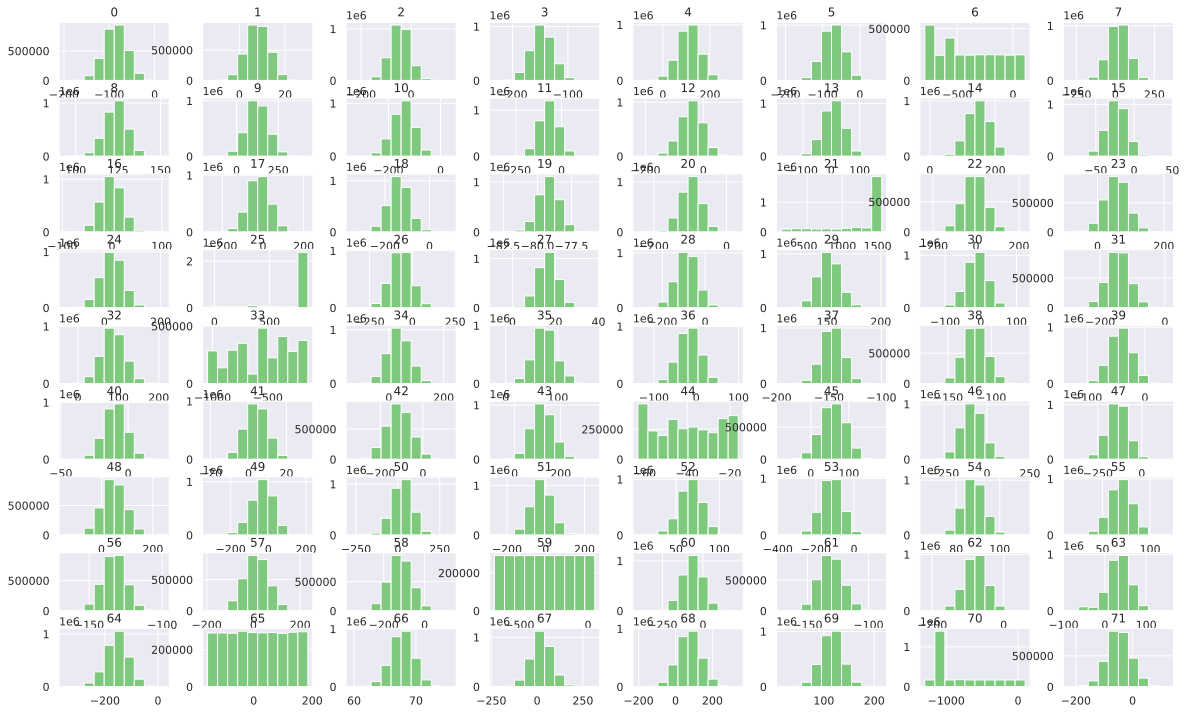

In [21]:
features = [col for col in X_base.columns if col != 'id']
X_base.hist(figsize=(20,12));

**Вывод по гистограммам**
- Наблюдаем ненормальное распределение данных в столбцах ['6', '21', '25', '33', '44', '59', '65', '70']
- Попробуем их удалить и посмотрим на финальные метрики поиска

Вывод EDA:

- есть аномальное распределение значений, которое может путать модель, попробуем удалить данные столбцы
- имеется большое количество выбросов
- большое количество признаков 

В нашей задаче необходимо подобрать 5 схожих товаров. База товаров большая, поэтому более точные решения для этой задачи (например полный перебор или k-d-деревья) могут занимать значительное время. Для решения данной задачи мы будем использовать приближенные методы поиска:

- Locality-sensitive hashing (LSH) - Предположим, что мы можем построить такую хеш-функцию, которая переводит близкие объекты в один бакет. Тогда близких соседей целевого объекта можно найти, посчитав его хеш и посмотрев на коллизии. К этому классу алгоритмов относится, например, FAISS, используемый Facebook.
- Random projection trees - алгоритм, основанный на деревьях. Идея всех таких методов заключается в итеративном разделении пространства случайными гиперплоскостями и построении на базе этого разделения дерева, в листах которого содержится малое число объектов. Одним из наиболее ярких представителей этого семейства является Annoy — алгоритм, который используется Spotify для рекомендаций музыки.

Все эти алгоритмы используют векторный поиск для уменьшения времени поиска  

Аномальные распределения значений в столбцах ['6', '21', '25', '33', '44', '59', '65', '70', '62'] удалим, так как они могут путать модель  удалим дубликаты. Выбросы оставим, так как пока не понятно какими значениями их заполнять, а также не понимая смысла столбца, не можем предположить может ли это значения являться характерным для той или иной классификации  

Большую размерность нашей матрицы попробуем нивелировать с помощью PCA и проанализируем итоговые метрики.

## Шаг 4. Корреляционный анализ

Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

In [22]:
interval_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [23]:
# Удаление столбца 'name'
data_without_id = X_train.drop('0', axis=1)
interval_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Вычисление матрицы корреляции Phi_K для данных без 'id'
phik_matrix = data_without_id.sample(1000).phik_matrix(interval_cols=interval_cols)


plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=0.5,
    figsize=(20, 15)
) 

/home/popf/soft/miniconda3/envs/practicum/lib/python3.12/site-packages/phik/phik.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, inplace=True)
/home/popf/soft/miniconda3/envs/practicum/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=10211) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/popf/soft/miniconda3/envs/practicum/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=10211) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


In [24]:
# Выведем столбцы у которых корреляция меньше 0,2
phik_matrix_np = phik_matrix.to_numpy()
good_rows = set()
all_rows = set()
for i in range(phik_matrix.shape[0]):
    all_rows.add(i)
    for j in range(i + 1, phik_matrix.shape[1]):
        if phik_matrix_np[i][j] > 0.2:
            good_rows.add(i)
all_rows.difference(good_rows)

{71}

**Вывод:**

столбцы с мультиколлинеарностью отсутствуют (>0.9)  

столбцы с высокой корреляцией (>0,5): 31

столбцы со средней корреляцией (>0,2): 2 4 7 11 14 21 22 26 27 29 35 40 42 44 52 64 66 68

## Шаг 5. Подготовка данных

In [25]:
targets = X_train["Target"]
X_train.drop(['Target', '6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)
X_test.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)
X_base.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)

После удаления столбцов и удаления дубликатов при использовании плоского индекса - метрика выросла с 11,5 до 77,1 на урезанном датасете

## Шаг 6. Определим оптимальное количество кластеров в нашем датасете

Задача кластеризации - это обучение без учителя.

Один из наиболее популярных методов кластеризации — это метод K-средних (K-means). Основная идея метода — итеративное повторение двух шагов:

1. распределение объектов выборки по кластерам;
2. пересчёт центров кластеров.

В начале работы алгоритма выбираются K случайных центров в пространстве признаков. Каждый объект выборки относят к тому кластеру, к центру которого объект оказался ближе. Далее центры кластеров пересчитывают как среднее арифметическое векторов признаков всех вошедших в этот кластер объектов (то есть центр масс кластера). Как только мы обновили центры кластеров, объекты заново перераспределяются по ним, а затем можно снова уточнить положение центров. Процесс продолжается до тех пор, пока центры кластеров не перестанут меняться.

Для определения качества кластеризации мы будем использовать показатели:

**Silhouette Coefficient**

Если основные истинные метки неизвестны, оценку необходимо выполнить с использованием самой модели. Коэффициент силуэта  является примером такой оценки, где более высокий балл коэффициента силуэта относится к модели с более четко определенными кластерами. Коэффициент силуэта определяется для каждого образца и состоит из двух баллов:

a: Среднее расстояние между образцом и всеми другими точками того же класса.

b: Среднее расстояние между образцом и всеми остальными точками в следующем ближайшем кластере. 

Он варьируется от [-1, 1], и максимизируется, когда кластеры кучные и хорошо отделены друг от друга. Изначально коэффициент определяется для каждого объекта выборки, а метрика для результатов кластеризации всей выборки вводится как средний коэффициент силуэта для всех объектов выборки.

**Индекс Дэвиса-Булдина (Davies-Bouldin)**

Если основные истинные метки неизвестны, для оценки модели можно использовать индекс Дэвиса-Булдина (sklearn.metrics.davies_bouldin_score), где более низкий индекс Дэвиса-Булдина относится к модели с лучшим разделением между кластерами.

Этот индекс означает среднее “сходство” между кластерами, где сходство - это мера, сравнивающая расстояние между кластерами с размером самих кластеров.

Ноль - это минимально возможный балл. Значения ближе к нулю указывают на лучшее разделение.

**v_measure_score**

V-мера - это среднее гармоническое значение между однородностью и полнотой:

Одним из основных недостатков любого метода кластеризации является сложность оценки его производительности. Для решения этой проблемы была разработана метрика V-мера. Для вычисления V-меры сначала требуется вычисление двух членов:-

Однородность: Идеально однородная кластеризация - это такая, при которой каждый кластер имеет точки данных, принадлежащие к одному и тому же классу меток. Однородность описывает близость алгоритма кластеризации к этому совершенству.

Полнота: Идеально полная кластеризация - это такая кластеризация, при которой все точки данных, принадлежащие одному классу, объединены в один кластер. Полнота описывает близость алгоритма кластеризации к этому совершенству.

Оценка от 0.0 до 1.0. 1.0 означает идеально полную маркировку.



In [26]:
def find_n_cluster(k_max, data):
    """
    Get the  score from clustering with different k
    """    
    sil, ks, db, vm = [], [], [], []
    for k in range(2, k_max):
        # initialize K-means, cluster and get labels
        km_cluster = sklearn.cluster.KMeans(n_clusters=k, random_state=12, init='k-means++')
        labels = km_cluster.fit_predict(data)

        # compute silhouette score
        sil.append(sklearn.metrics.silhouette_score(data, labels))
        db.append(sklearn.metrics.davies_bouldin_score(data,labels))
        vm.append(sklearn.metrics.v_measure_score(targets,labels))
        ks.append(k)

    return ks, sil, db, vm

In [27]:
# ks, sil, db, vm = find_n_cluster(1000, X_train)

In [28]:
# max_sil = max(sil)
# max_indices = [i for i, x in enumerate(sil) if x == max_sil]
# max_index = max_indices[0]

# min_db = min(db)
# min_indices_db = [i for i, x in enumerate(db) if x == min_db]
# min_index_db = min_indices_db[0]

# max_vm = max(vm)
# max_indices_vm = [i for i, x in enumerate(vm) if x == max_vm]
# max_index_vm = max_indices_vm[0]

# print("Silhouette score ", max_sil, " for number of cluster(s):", ks[max_index])
# print("Davies Bouldin score ", min_db, " for number of cluster(s):", ks[min_index_db])
# print("V-measure score  ", max_vm, " for number of cluster(s):", ks[max_index_vm])


**Вывод:**

код закомментировала, так как выполняется больше 2 часов

- Silhouette score  0.06425949452478452  for number of cluster(s): 147, данная метрика должна стремится к единицы, текущий показатель говорит, что разбивка на кластеры была далеко не оптимальной

- Davies Bouldin score  2.1604840174453037  for number of cluster(s): 998, показатель должен стремится к 0, и здесь на максимальном количестве кластеров метрика довольно высокая

- V-measure score   0.8434511709665127  for number of cluster(s): 999, этот показатель имеет приемлемое значение, возможно, из-за особенностей формы кластеров

Также ранее были проведены испытания на полной выборке и silhouette_score был 0.065 при  120, 217 и 404 кластерах

## Шаг 7. FAISS поиск 5 похожих товаров

**Locality-sensitive hashing (LSH)**

Предположим, что мы можем построить такую хеш-функцию, которая переводит близкие объекты в один бакет. Тогда близких соседей целевого объекта можно найти, посчитав его хеш и посмотрев на коллизии. К этому классу алгоритмов относится, FAISS, используемый Facebook.

К плюсам алгоритма можно отнести хорошие теоретические гарантии на сублинейное время и, как и в Annoy, простой поиск компромисса между точностью и скоростью работы. Минусами можно назвать высокую потребность в памяти, плохую адаптируемость под GPU, а также тот факт, что, несмотря на теоретические гарантии в среднем, на практике алгоритм может работать даже чуть дольше полного перебора из-за того, что, помимо самого поиска, требуется искать хеши объектов.

In [29]:
# Зададим базовые константы
faiss_n_clust = 8 #faiss_n_clust : int. Number of clusters for FAISS.
faiss_ef_search = 32 # - faiss_ef_search : int. Number of entry points for IVFHNSW index.
faiss_train_sample_size = None # faiss_train_sample_size : int. FAISS train sample size.
k_similar = 5
SEED = 42
faiss_pca_dims = 64

# Определим длину вектора признаков.
dims = X_base.shape[1]

# Определим базовый индекс.
base_index = {k: v for k, v in enumerate(X_base.index.to_list())}

### FAISS с PCA с индексом IVFFLAT

Попробуем снизить размерность датасета, для этого воспользуемся алгоритмом PCA

Метод главных компонент (Principal Component Analysis или же PCA) — алгоритм обучения без учителя, используемый для понижения размерности и выявления наиболее информативных признаков в данных. Его суть заключается в предположении о линейности отношений данных и их проекции на подпространство ортогональных векторов, в которых дисперсия будет максимальной.

Такие вектора называются главными компонентами и они определяют направления наибольшей изменчивости (информативности) данных. Альтернативно суть PCA можно определить как линейное проецирование, минимизирующее среднеквадратичное расстояние между исходными точками и их проекциями.

Методом перебора определила параметр faiss_pca_dims = 64 (63.065, 212.24)

In [30]:
def togpu(idx):
    return faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, idx)

quantizer = faiss.IndexFlatL2(dims)
# quantizer = faiss.index_cpu_to_gpu(res, 0, quantizer)

faiss_metric = 'mahalanobis'
pca_matrix = faiss.PCAMatrix(dims, faiss_pca_dims)
pca_matrix.train(X_base)
assert pca_matrix.is_trained
df_arr = pca_matrix.apply(X_base)
df_eval_arr = pca_matrix.apply(X_train)

dims = faiss_pca_dims

df = df_arr
df_eval = df_eval_arr
# Вычислим матрицу ковариации.
df_c = df - df.mean(0)
cov = np.dot(df_c.T, df_c) / df_c.shape[0]

# Преобразуем ковариационную матрицу.
L = np.linalg.cholesky(cov)
mahalanobis_transform = np.linalg.inv(L)

# Функция преобразования данных.
def inverse_cholesky_cov(df, mahalanobis_transform):
    df_trans = np.dot(df, mahalanobis_transform.T)
    return df_trans.astype('float32')

# Преобразуем данные.
df_arr = inverse_cholesky_cov(df,
                            mahalanobis_transform)
df_eval_arr = inverse_cholesky_cov(df_eval,
                                mahalanobis_transform)

def togpu(idx):
    return faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, idx)

# Определим индекс.
faiss_index = faiss.IndexIVFFlat(quantizer,
                                dims,
                                faiss_n_clust,
                                faiss.METRIC_L2)
faiss_index = togpu(faiss_index)

start_faiss = time.perf_counter()

faiss_index.train(df_arr[:faiss_train_sample_size, :])
faiss_index.add(df_arr)

# Построим индекс.
vecs, idx = faiss_index.search(df_eval_arr, k_similar)

# Вычислим целевую метрику accuracy@k для FAISS.
acc_faiss_pca = 0
for t, el in zip(targets.values.tolist(), idx):
    acc_faiss_pca += int(t in [base_index[r] for r in el])

# Вычислим время выполнения.
time_faiss_pca = time.perf_counter() - start_faiss


In [31]:
# Выведем результаты:
acc_faiss_pca = round((100 * acc_faiss_pca / len(idx)), 3)

time_faiss_pca = round(time_faiss_pca, 2)

print('Метрика acc@5 с применением метода PCA64: ', acc_faiss_pca, '%, время выполнения: ', time_faiss_pca)

Метрика acc@5 с применением метода PCA64:  64.128 %, время выполнения:  42.44


In [32]:
results_table = {
    'FAISS IVFFlat PCA64':[faiss_metric, acc_faiss_pca, time_faiss_pca]
}

In [33]:
pd.DataFrame(
    results_table, index=[
        'metric', 'acc@5', 'time'
    ]
).transpose()

metric  acc@5   time
FAISS IVFFlat PCA64  mahalanobis 64.128 42.440

### FAISS с индексом IVFFLAT

In [34]:
dims = X_base.shape[1]
def togpu(idx):
    return faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, idx)

res = faiss.StandardGpuResources()  # use a single GPU
quantizer = faiss.IndexFlatL2(dims)
# quantizer = faiss.index_cpu_to_gpu(res, 0, quantizer)

faiss_metric = 'mahalanobis'
df = X_base
df_eval = X_train
# Вычислим матрицу ковариации.
df_c = df - df.mean(0)
cov = np.dot(df_c.T, df_c) / df_c.shape[0]

# Преобразуем ковариационную матрицу.
L = np.linalg.cholesky(cov)
mahalanobis_transform = np.linalg.inv(L)

# Функция преобразования данных.
def inverse_cholesky_cov(df, mahalanobis_transform):
    df_trans = np.dot(df, mahalanobis_transform.T)
    return df_trans.astype('float32')

# Преобразуем данные.
df_arr = inverse_cholesky_cov(df,
                            mahalanobis_transform)
df_eval_arr = inverse_cholesky_cov(df_eval,
                                mahalanobis_transform)

# Определим индекс.
faiss_index = faiss.IndexIVFFlat(quantizer,
                                dims,
                                faiss_n_clust,
                                faiss.METRIC_L2)
faiss_index = togpu(faiss_index)
start_faiss = time.perf_counter()

faiss_index.train(df_arr[:faiss_train_sample_size, :])
faiss_index.add(df_arr)

# Построим индекс.
vecs, idx = faiss_index.search(df_eval_arr, k_similar)

# Вычислим целевую метрику accuracy@k для FAISS.
acc_faiss_mach = 0
for t, el in zip(targets.values.tolist(), idx):
    acc_faiss_mach += int(t in [base_index[r] for r in el])

# Вычислим время выполнения.
time_faiss_mach = time.perf_counter() - start_faiss


In [35]:
# Выведем результаты:
acc_faiss_mach = round((100 * acc_faiss_mach / len(idx)), 3)

time_faiss_mach = round(time_faiss_mach, 2)

print('Метрика acc@5 с применением метода PCA64: ', acc_faiss_mach, '%, время выполнения: ', time_faiss_mach)

Метрика acc@5 с применением метода PCA64:  64.197 %, время выполнения:  41.88


In [36]:
results_table['FAISS IVFFlat '+ faiss_metric] = [
    faiss_metric,
    acc_faiss_mach,
    time_faiss_mach
]

In [37]:
pd.DataFrame(
    results_table, index=[
        'metric', 'acc@5', 'time'
    ]
).transpose()

metric  acc@5   time
FAISS IVFFlat PCA64        mahalanobis 64.128 42.440
FAISS IVFFlat mahalanobis  mahalanobis 64.197 41.880

### FAISS с индексом IVFFLAT

Эффективно хранить и быстро получать векторы, принадлежащие центроиду, помогает простой трюк под названием inverted file.

В IVF инвертируем присвоение. Теперь центроидам сопоставляются списки векторов. Так мы можем быстро находить кандидатов, посчитав расстояния до центроидов, а затем брать уже готовый список для ближайшего.


In [38]:
faiss_metric = 'euclidean'

# Приведём данные в соответстие faiss.
df_arr = np.ascontiguousarray(X_base.values).astype('float32')
df_eval_arr = (
    np.ascontiguousarray(X_train.values).astype('float32')
    )

# Нормализуем векторы.
faiss.normalize_L2(df_arr)
faiss.normalize_L2(df_eval_arr)

# Определим индекс.
faiss_index = faiss.IndexIVFFlat(quantizer,
                                dims,
                                faiss_n_clust)
faiss_index = togpu(faiss_index)

start_faiss = time.perf_counter()

faiss_index.train(df_arr[:faiss_train_sample_size, :])
faiss_index.add(df_arr)

# Построим индекс.
vecs, idx = faiss_index.search(df_eval_arr, k_similar)

# Вычислим целевую метрику accuracy@k для FAISS.
acc_faiss_euc = 0
for t, el in zip(targets.values.tolist(), idx):
    acc_faiss_euc += int(t in [base_index[r] for r in el])

# Вычислим время выполнения.
time_faiss_euc = time.perf_counter() - start_faiss

acc_faiss_euc = round((100 * acc_faiss_euc / len(idx)), 3)

time_faiss_euc = round(time_faiss_euc, 2)

print('Метрика acc@5 faiss_metric = euclidean: ', acc_faiss_euc, '%, время выполнения: ', time_faiss_euc)

Метрика acc@5 faiss_metric = euclidean:  62.551 %, время выполнения:  38.79


In [39]:
results_table['FAISS IVFFlat '+ faiss_metric] = [
    faiss_metric,
    acc_faiss_euc,
    time_faiss_euc
]

In [40]:
pd.DataFrame(
    results_table, index=[
        'metric', 'acc@5', 'time'
    ]
).transpose()

metric  acc@5   time
FAISS IVFFlat PCA64        mahalanobis 64.128 42.440
FAISS IVFFlat mahalanobis  mahalanobis 64.197 41.880
FAISS IVFFlat euclidean      euclidean 62.551 38.790

In [41]:
# FAISS с косинусным расстоянием.
faiss_metric = 'cosine'

# Приведём данные в соответстие faiss.
df_arr = np.ascontiguousarray(X_base.values).astype('float32')
df_eval_arr = (
    np.ascontiguousarray(X_train.values).astype('float32')
    )

# Нормализуем векторы.
faiss.normalize_L2(df_arr)
faiss.normalize_L2(df_eval_arr)

# Определим индекс.
faiss_index = faiss.IndexIVFFlat(quantizer,
                                dims,
                                faiss_n_clust,
                                faiss.METRIC_INNER_PRODUCT)

faiss_index = togpu(faiss_index)


start_faiss = time.perf_counter()

faiss_index.train(df_arr[:faiss_train_sample_size, :])
faiss_index.add(df_arr)

# Построим индекс.
vecs, idx = faiss_index.search(df_eval_arr, k_similar)

# Вычислим целевую метрику accuracy@k для FAISS.
acc_faiss_cos = 0
for t, el in zip(targets.values.tolist(), idx):
    acc_faiss_cos += int(t in [base_index[r] for r in el])

# Вычислим время выполнения.
time_faiss_cos = time.perf_counter() - start_faiss

acc_faiss_cos = round((100 * acc_faiss_cos / len(idx)), 3)

time_faiss_cos = round(time_faiss_cos, 2)

print('Метрика acc@5 с косинусным расстоянием: ', acc_faiss_cos, '%, время выполнения: ', time_faiss_cos)

Метрика acc@5 с косинусным расстоянием:  62.541 %, время выполнения:  35.72


In [42]:
results_table['FAISS IVFFlat '+ faiss_metric] = [
    faiss_metric,
    acc_faiss_cos,
    time_faiss_cos
]

In [43]:
pd.DataFrame(
    results_table, index=[
        'metric', 'acc@5', 'time'
    ]
).transpose()

metric  acc@5   time
FAISS IVFFlat PCA64        mahalanobis 64.128 42.440
FAISS IVFFlat mahalanobis  mahalanobis 64.197 41.880
FAISS IVFFlat euclidean      euclidean 62.551 38.790
FAISS IVFFlat cosine            cosine 62.541 35.720

In [44]:
# # FAISS с поиском максимального скалярного произведения.

faiss_metric = 'mips'

# Приведём данные в соответстие faiss.
df_arr = np.ascontiguousarray(X_base.values).astype('float32')
df_eval_arr = (
    np.ascontiguousarray(X_train.values).astype('float32')
    )

# Нормализуем векторы.
faiss.normalize_L2(df_arr)
faiss.normalize_L2(df_eval_arr)

# Определим индекс.
faiss_index = faiss.IndexIVFFlat(quantizer,
                                dims,
                                faiss_n_clust,
                                faiss.METRIC_INNER_PRODUCT)

faiss_index = togpu(faiss_index)


start_faiss = time.perf_counter()

faiss_index.train(df_arr[:faiss_train_sample_size, :])
faiss_index.add(df_arr)

# Построим индекс.
vecs, idx = faiss_index.search(df_eval_arr, k_similar)

# Вычислим целевую метрику accuracy@k для FAISS.
acc_faiss_mips = 0
for t, el in zip(targets.values.tolist(), idx):
    acc_faiss_mips += int(t in [base_index[r] for r in el])

# Вычислим время выполнения.
time_faiss_mips = time.perf_counter() - start_faiss

acc_faiss_mips = round((100 * acc_faiss_mips / len(idx)), 3)

time_faiss_mips = round(time_faiss_mips, 2)

print('Метрика acc@5 с поиском максимального скалярного произведения: ', acc_faiss_mips, '%, время выполнения: ', time_faiss_mips)

Метрика acc@5 с поиском максимального скалярного произведения:  62.541 %, время выполнения:  36.92


In [45]:
results_table['FAISS IVFFlat '+ faiss_metric] = [
    faiss_metric,
    acc_faiss_mips,
    time_faiss_mips
]

In [46]:
pd.DataFrame(
    results_table, index=[
        'metric', 'acc@5', 'time'
    ]
).transpose()

metric  acc@5   time
FAISS IVFFlat PCA64        mahalanobis 64.128 42.440
FAISS IVFFlat mahalanobis  mahalanobis 64.197 41.880
FAISS IVFFlat euclidean      euclidean 62.551 38.790
FAISS IVFFlat cosine            cosine 62.541 35.720
FAISS IVFFlat mips                mips 62.541 36.920

### FAISS с индексом FLATL2

In [47]:
# Приведём данные в соответстие faiss.
df_arr = np.ascontiguousarray(X_base.values).astype('float32')
df_eval_arr = (
    np.ascontiguousarray(X_train.values).astype('float32')
    )

# Нормализуем векторы.
faiss.normalize_L2(df_arr)
faiss.normalize_L2(df_eval_arr)

# Определим индекс.
idx_l2 = faiss.IndexFlatL2(dims)

idx_l2 = togpu(idx_l2)


start_faiss = time.perf_counter()

idx_l2.train(df_arr[:faiss_train_sample_size, :])
idx_l2.add(df_arr)

# Построим индекс.
vecs, idx = idx_l2.search(df_eval_arr, k_similar)

# Вычислим целевую метрику accuracy@k для FAISS.
acc_faiss_flat = 0
for t, el in zip(targets.values.tolist(), idx):
    acc_faiss_flat += int(t in [base_index[r] for r in el])

# Вычислим время выполнения.
time_faiss_flat = time.perf_counter() - start_faiss

acc_faiss_flat = round((100 * acc_faiss_flat / len(idx)), 3)

time_faiss_flat = round(time_faiss_flat, 2)

print(acc_faiss_flat, time_faiss_flat)
print('Метрика acc@5 с индексом FLATL2: ', acc_faiss_flat, '%, время выполнения: ', time_faiss_flat)

69.726 25.04
Метрика acc@5 с индексом FLATL2:  69.726 %, время выполнения:  25.04


In [48]:
results_table['FAISS FlatL2'] = [
    faiss_metric,
    acc_faiss_flat,
    time_faiss_flat
]

In [49]:
pd.DataFrame(
    results_table, index=[
        'metric', 'acc@5', 'time'
    ]
).transpose()

metric  acc@5   time
FAISS IVFFlat PCA64        mahalanobis 64.128 42.440
FAISS IVFFlat mahalanobis  mahalanobis 64.197 41.880
FAISS IVFFlat euclidean      euclidean 62.551 38.790
FAISS IVFFlat cosine            cosine 62.541 35.720
FAISS IVFFlat mips                mips 62.541 36.920
FAISS FlatL2                      mips 69.726 25.040

### FAISS с индексом IVF_HNSW64

Следующий класс алгоритмов основан на построении специального графа близости (proximity graph) на объектах выборки и дальнейшем жадном поиске по этому графу. Алгоритмы этого семейства сейчас считаются state-of-the-art (SotA) для многих задач.

Поиск начинается в самом верхнем слое. После нахождения ближайшей к целевому объекту вершины спускаемся на слой ниже и начинаем поиск из этой вершины. Повторяем процедуру, пока не спустимся до нулевого слоя. Таким образом, на каждом слое мы всё больше уточняем наш ответ. Стоит отметить, что для ускорения работы иногда поиск останавливают не при нахождении ближайшей вершины, а раньше, используя критерии остановки.

Интуитивно легко понять, почему такая иерархическая структура решает проблему плотных кластеров: в верхних слоях вершин мало, а расстояния между ними в среднем большие, а значит, таких кластеров там почти нет. Поэтому, попадая в нижний слой, мы чаще всего оказываемся уже в нужном кластере и просто уточняем результат работы алгоритма.

In [50]:
# Приведём данные в соответстие faiss.
df_arr = np.ascontiguousarray(X_base.values).astype('float32')
df_eval_arr = (
    np.ascontiguousarray(X_train.values).astype('float32')
    )
# Определим индекс.
faiss_index = faiss.index_factory(dims,
                                    (f'IVF{faiss_n_clust}_HNSW'+
                                    f'{faiss_ef_search}'+',Flat'))

faiss_index = togpu(faiss_index)

faiss_index.nprobe = 16

start_faiss = time.perf_counter()

faiss_index.train(df_arr[:faiss_train_sample_size, :])
faiss_index.add(df_arr)

# Построим индекс.
vecs, idx = faiss_index.search(df_eval_arr, k_similar)

# Вычислим целевую метрику accuracy@k для FAISS.
acc_faiss_hnsw = 0
for t, el in zip(targets.values.tolist(), idx):
    acc_faiss_hnsw += int(t in [base_index[r] for r in el])

# Вычислим время выполнения.
time_faiss_hnsw = time.perf_counter() - start_faiss

acc_faiss_hnsw = round((100 * acc_faiss_hnsw / len(idx)), 3)

time_faiss_hnsw = round(time_faiss_hnsw, 2)

print('Метрика acc@5 с индексом HNSW: ', acc_faiss_hnsw, '%, время выполнения: ', time_faiss_hnsw)

Метрика acc@5 с индексом HNSW:  69.654 %, время выполнения:  255.53


In [51]:
results_table['FAISS HNSW'] = [
    faiss_metric,
    acc_faiss_hnsw,
    time_faiss_hnsw
]

In [52]:
pd.DataFrame(
    results_table, index=[
        'metric', 'acc@5', 'time'
    ]
).transpose()

metric  acc@5    time
FAISS IVFFlat PCA64        mahalanobis 64.128  42.440
FAISS IVFFlat mahalanobis  mahalanobis 64.197  41.880
FAISS IVFFlat euclidean      euclidean 62.551  38.790
FAISS IVFFlat cosine            cosine 62.541  35.720
FAISS IVFFlat mips                mips 62.541  36.920
FAISS FlatL2                      mips 69.726  25.040
FAISS HNSW                        mips 69.654 255.530

## ANNOY

Алгоритмы, основанные на деревьях, очень часто применяются в задачах поиска соседей. Идея всех таких методов заключается в итеративном разделении пространства случайными гиперплоскостями и построении на базе этого разделения дерева, в листах которого содержится малое число объектов.

Одним из наиболее ярких представителей этого семейства является Annoy — алгоритм, который используется Spotify для рекомендаций музыки. Задача подобных рекомендательных систем довольно простая — нужно посоветовать пользователю композиции, которые он ещё не слушал, но которые при этом с высокой вероятностью ему понравятся. Простая и рабочая идея — предлагать композиции, похожие на те, которые он уже слушает. Здесь на помощь как раз и приходят методы поиска ближайших соседей.

Annoy в какой-то степени похож на k-d-деревья. Сначала выбираются два случайных объекта обучающей выборки и проводится гиперплоскость, симметрично их разделяющая. Затем для каждого полученного полупространства итеративно запускается такая же процедура, которая продолжается до тех пор, пока в каждой области будет не более M объектов (M — гиперпараметр).

Чем больше таких деревьев берётся, тем более точным будет результат, но придётся тратить большее время на его поиск.

Варианты метрик расстояний между векторами:
- 'euclidean';
- 'angular' for cosine distance;
- 'manhattan';
- 'hamming';
- 'dot'.

Наилучший результат выходит с применением манхэттенского расстояния

In [53]:
# dims = X_base.shape[1]
# SEED = 42

In [54]:
annoy_distance_type = 'manhattan'
annoy_n_trees = 100
annoy_search_n_nodes = -1

# Определим индекс ANNOY.
# annoy_index = AnnoyIndex(dims, annoy_distance_type)
annoy_index = AnnoyIndex(dims, annoy_distance_type)


# annoy_index.set_seed(SEED)
# Добавим векторы и их индексы.
for i, v in zip(range(X_base.shape[0]), X_base.values):
    annoy_index.add_item(i, v)

# Построим индекс.
annoy_index.build(annoy_n_trees, n_jobs=-1)

start_annoy = time.perf_counter()

# Получим K похожих элементов для каждого запроса и собрём в список.
idx = []
for v in X_train.values:
    idx.append(annoy_index.get_nns_by_vector(
        v,
        k_similar,
        search_k=annoy_search_n_nodes)
    )

# Вычислим целевую метрику accuracy@k для ANNOY.
acc_annoy = 0
for t, el in zip(targets.values.tolist(), idx):
    acc_annoy += int(t in [base_index[r] for r in el])

# Вычислим время выполнения.
time_annoy = time.perf_counter() - start_annoy

# Выведем метрику и время исполнения для каждого/всех алгоритмов.
acc_annoy = round((100 * acc_annoy / len(idx)), 3)
time_annoy = round(time_annoy, 2)

print('Метрика acc@5 ANNOY: ', acc_annoy, '%, время выполнения: ', time_annoy)

Метрика acc@5 ANNOY:  66.755 %, время выполнения:  26.67


In [55]:
results_table['ANNOY '+annoy_distance_type] = [
    annoy_distance_type,
    acc_annoy,
    time_annoy
    
]

In [56]:
pd.DataFrame(
    results_table, index=[
        'metric', 'acc@5', 'time'
    ]
).transpose()

metric  acc@5    time
FAISS IVFFlat PCA64        mahalanobis 64.128  42.440
FAISS IVFFlat mahalanobis  mahalanobis 64.197  41.880
FAISS IVFFlat euclidean      euclidean 62.551  38.790
FAISS IVFFlat cosine            cosine 62.541  35.720
FAISS IVFFlat mips                mips 62.541  36.920
FAISS FlatL2                      mips 69.726  25.040
FAISS HNSW                        mips 69.654 255.530
ANNOY manhattan              manhattan 66.755  26.670

## Вывод

Цель исследования: рзработать механизм поиска 5 ближайших товаров из постоянно меняющегося датасета

Задачи:
1  Подобрать оптимальный механизм кластеризации и поиска для оптимального tradeoff между качеством и скоростью поиска похожих товаров 
2  Учитывать критерии успеха работы:
    - время работы алгоритма не больше 8 часов на датасетах больше 5 млн строк
    - метрика качества поиска должна быть больше 70%
    - датасет постоянно обновляет товары

Ход работы:

Для реализации таких задач чаще всего применяют векторный поиск. К плюсам можно отнести достаточный гибкий подбор гиперпараметров для выбора между временем и точностью, различные подходы к хранению индексов, которые позволяют уменьшить объем хранимой информации (в оперативной памяти) и затраченного времени (возможность работы на GPU). к минуса - это все же приблеженный поиск и на больших объемах информации приходится жертвовать точностью. 

В ходе исследования были рассмотрены два алгоритма:
- FAISS: Locality-sensitive hashing (LSH) поиск близких соседей целевого объекта можно найти, посчитав его хеш и посмотрев на коллизии. Минусами можно назвать высокую потребность в памяти, плохую адаптируемость под GPU, а также тот факт, что, несмотря на теоретические гарантии в среднем, на практике алгоритм может работать даже чуть дольше полного перебора из-за того, что, помимо самого поиска, требуется искать хеши объектов.
- ANNOY: Алгоритмы, основанные на деревьях, очень часто применяются в задачах поиска соседей. Идея всех таких методов заключается в итеративном разделении пространства случайными гиперплоскостями и построении на базе этого разделения дерева, в листах которого содержится малое число объектов. К минусам можнот отнести высокое время поиска и невозможность выйти из низлежайщих слоев, чтобы найти точку рядом

С практической точки зрения ANNOY мне понравился больше:
- простая и понятная документация с минимальным количеством настраиваемых гиперпараметров
-  скорость работы на маленьком датасете и небольшом количестве деревьев - фантастически маленькая

Характеристики датасета:
- большой размер, поэтому эксперименты необходимо было проводить на маленьком объеме, что завышло метрику  
- большое количество выбросов / или это были характеристики другого класса объектов
- имелись дубликаты

Проводимые эксперименты на small_dataset:
1. Реализация MVP - метрика 11,5 с применением FAISS
2. Удаление дубликатов: метрика увеличилась на 0,9% = 12,4%
3. Удаление неинформативных столбцов: acc@5 = 65,4%
4. FAISS IndexFlatL2: acc@5 = 77.1%
5. FAISS IndexHNSW(n_clust = 8, k_similar = 20): acc@5 score/time 80.935%/25.58s
6. FAISS IndexHNSW(n_clust = 8, k_similar = 5): acc@5 score/time 77.071% 25.75s
7. Библиотека ANNOY  с default параметрами - 55.002%/4.92s


Итоговая проверка на full_dataset:
1. FAISS IndexHNSW(n_clust = 8, k_similar = 5): acc@5 score/time 69.682% 5660.35s
2. Библиотека ANNOY  с default параметрами - 55.002%/4.92s

Видим что на полной выборке время выполнения алгоритма возрстает существенно.

Был автоматизирован способ расчета разных индексов в FAISS и подобраны оптимальные параметры в ANNOY.

### Итоговая таблица для сравнения поиск на CPU:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>metric</th>
      <th>acc@5</th>
      <th>time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FAISS PCA64</th>
      <td>mahalanobis</td>
      <td>69.127</td>
      <td>3.260</td>
    </tr>
    <tr>
      <th>FAISS euclidean</th>
      <td>euclidean</td>
      <td>77.204</td>
      <td>27.910</td>
    </tr>
    <tr>
      <th>FAISS cosine</th>
      <td>cosine</td>
      <td>77.194</td>
      <td>19.810</td>
    </tr>
    <tr>
      <th>FAISS mips</th>
      <td>mips</td>
      <td>77.194</td>
      <td>24.290</td>
    </tr>
    <tr>
      <th>FAISS FlatL2</th>
      <td>mips</td>
      <td>77.214</td>
      <td>4.680</td>
    </tr>
    <tr>
      <th>FAISS HNSW</th>
      <td>mips</td>
      <td>77.071</td>
      <td>19.390</td>
    </tr>
    <tr>
      <th>ANNOY</th>
      <td>euclidean</td>
      <td>76.907</td>
      <td>61.240</td>
    </tr>
    <tr>
      <th>ANNOYangular</th>
      <td>angular</td>
      <td>76.937</td>
      <td>330.670</td>
    </tr>
    <tr>
      <th>ANNOY manhattan</th>
      <td>manhattan</td>
      <td>77.604</td>
      <td>1780.300</td>
    </tr>
    <tr>
      <th>FAISS IVFFlat mahalanobis</th>
      <td>mahalanobis</td>
      <td>68.963</td>
      <td>2.830</td>
    </tr>
  </tbody>
</table>
</div>

**Результаты на  CPU**
1. ANNOY manhattan 
2. FAISS FLATL2 логично, так как это фактически перебор
3. FAISS cos/mips

### Поиск на GPU

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>metric</th>
      <th>acc@5</th>
      <th>time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>FAISS IVFFlat PCA64</th>
      <td>mahalanobis</td>
      <td>64.128</td>
      <td>42.440</td>
    </tr>
    <tr>
      <th>FAISS IVFFlat mahalanobis</th>
      <td>mahalanobis</td>
      <td>64.197</td>
      <td>41.880</td>
    </tr>
    <tr>
      <th>FAISS IVFFlat euclidean</th>
      <td>euclidean</td>
      <td>62.551</td>
      <td>38.790</td>
    </tr>
    <tr>
      <th>FAISS IVFFlat cosine</th>
      <td>cosine</td>
      <td>62.541</td>
      <td>35.720</td>
    </tr>
    <tr>
      <th>FAISS IVFFlat mips</th>
      <td>mips</td>
      <td>62.541</td>
      <td>36.920</td>
    </tr>
    <tr>
      <th>FAISS FlatL2</th>
      <td>mips</td>
      <td>69.726</td>
      <td>25.040</td>
    </tr>
    <tr>
      <th>FAISS HNSW</th>
      <td>mips</td>
      <td>69.654</td>
      <td>255.530</td>
    </tr>
    <tr>
      <th>ANNOY manhattan</th>
      <td>manhattan</td>
      <td>66.755</td>
      <td>26.670</td>
    </tr>
  </tbody>
</table>
</div>

**Результаты на  CPU**
1. FAISS HNSW 
2. FAISS FLATL2 логично, так как это фактически перебор
3. ANNOY manhattan

### Что хочется доделать:
- найти способ определения оптимального количества кластеров  Есть гипотеза что для кластеризации можно попробовать использовать иерархическую кластеризацию, так как возможно точки разных категорий товаров лежат очень близко друг к другу
-  разобраться почему силуэтный индекс такой маленький, подобрать оптимальное количество кластеров исходя из метрик и типа кластеризации
- сделать функцию которая будет определять оптимальное соотношение времени и точности, разные типы расстояний и индексов
- разобраться с разной реализацией с применением GPU и CPU. ГИпотеза что будет отличаться только время выполнения